In [108]:
import os
import logging

import scanpy as sc
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pytorch_lightning as pl
import wandb
from einops import rearrange, reduce
from timm import create_model
from torch.utils.data import DataLoader, Dataset
from typing import Optional, List

In [4]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [33]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

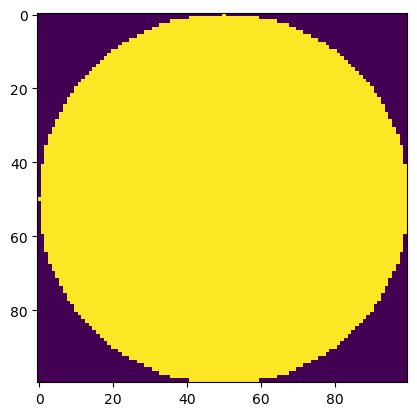

In [35]:
m = create_circular_mask(100, 100)
plt.imshow(m)


## input data

In [11]:
a1 = sc.read_visium('/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U2')
a1.var_names_make_unique()

a2 = sc.read_visium('/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U3')
a2.var_names_make_unique()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
he1 = tifffile.imread('/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif')
he2 = tifffile.imread('/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif')
he1.shape, he2.shape

((19915, 19641, 3), (19921, 19648, 3))

In [44]:
def rescale_img(img, scale=.5, shape=None):
    if shape is None:
        h, w = int(img.shape[0] * scale), int(img.shape[1] * scale)
    else:
        h, w = shape
    scaled = TF.resize(rearrange(torch.Tensor(img), 'h w c -> c h w'), size=(h, w))
    return rearrange(scaled, 'c h w -> h w c').numpy().astype(np.uint8)

def rescale_with_pad(img, scale=.5, shape=None, padding_mode='reflect'):
    if shape is None:
        h, w = int(img.shape[0] * scale), int(img.shape[1] * scale)
    else:
        h, w = shape
    r, c = img.shape[0], img.shape[1]
    
    right_pad = r-c if r>c else 0
    bottom_pad = c-r if c>r else 0
    padded = TF.pad(rearrange(torch.Tensor(img), 'h w c -> c h w'),
                    padding=[0, 0, right_pad, bottom_pad], padding_mode=padding_mode)
    
    scaled = TF.resize(padded, size=(h, w))
    return rearrange(scaled, 'c h w -> h w c').numpy().astype(np.uint8)

def incorporate_hi_res(adata, he, scale=.05):
    spot_diameter = next(iter(adata.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres']
    spot_diameter, spot_radius = int(spot_diameter), int(spot_diameter / 2)
    c_min, r_min = np.min(adata.obsm['spatial'], axis=0) - spot_radius
    c_max, r_max = np.max(adata.obsm['spatial'], axis=0) + spot_radius

    adata.uns['trimmed'] = he[r_min:r_max, c_min:c_max]
    adata.obsm['spatial_trimmed'] = adata.obsm['spatial'] + np.asarray([-c_min, -r_min])
    
    adata.uns[f'trimmed_{scale}'] = rescale_img(adata.uns['trimmed'], scale=scale)
    adata.uns[f'spatial_trimmed_{scale}'] = adata.obsm['spatial_trimmed'] * scale
    
    sr = int(scale * spot_radius)
    labeled_img = np.zeros((adata.uns[f'trimmed_{scale}'].shape[0], adata.uns[f'trimmed_{scale}'].shape[1]),
                           dtype=np.uint32)
    footprint = create_circular_mask(sr * 2, sr * 2)
    for i, (c, r) in enumerate(adata.uns[f'spatial_trimmed_{scale}']):
        r, c = int(r), int(c)
        rect = np.zeros((sr * 2, sr * 2))
        rect[footprint>0] = i + 1
        labeled_img[r-sr:r+sr, c-sr:c+sr] = rect
    adata.uns[f'trimmed_{scale}_labeled_img'] = labeled_img
    
    return adata

In [50]:
scale = .05
a1 = incorporate_hi_res(a1, he1, scale=scale)
a2 = incorporate_hi_res(a2, he2, scale=scale)

In [51]:
a1.uns.keys()

odict_keys(['spatial', 'trimmed', 'trimmed_0.05', 'spatial_trimmed_0.05', 'trimmed_00.05', 'spatial_trimmed_00.05', 'trimmed_{scale}_labeled_img', 'trimmed_0.05_labeled_img'])

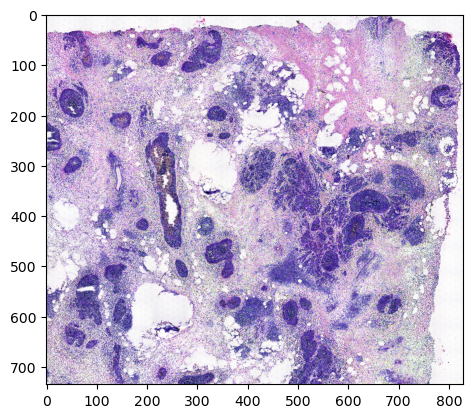

In [52]:
plt.imshow(a1.uns[f'trimmed_{scale}'])

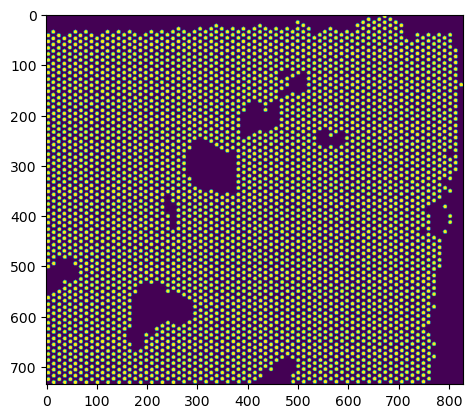

In [53]:
plt.imshow(a1.uns[f'trimmed_{scale}_labeled_img'] > 0)

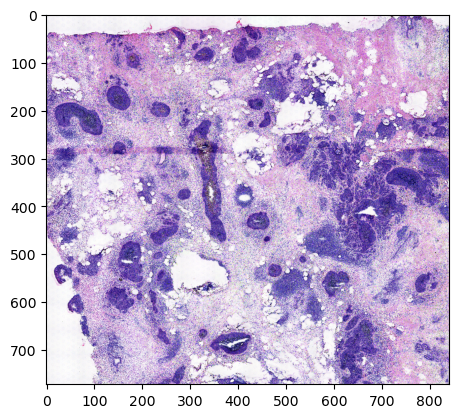

In [54]:
plt.imshow(a2.uns[f'trimmed_{scale}'])

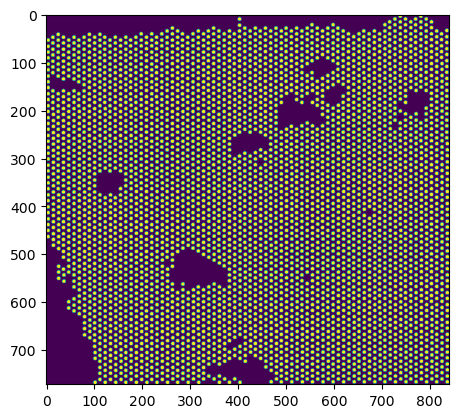

In [55]:
plt.imshow(a2.uns[f'trimmed_{scale}_labeled_img'] > 0)

In [56]:
a1.uns[f'trimmed_{scale}'].shape, a2.uns[f'trimmed_{scale}'].shape

((735, 829, 3), (772, 840, 3))

In [202]:
fixed = torch.tensor(rearrange(a1.uns[f'trimmed_{scale}'], 'h w c -> c h w'))
moving = torch.tensor(rearrange(a2.uns[f'trimmed_{scale}'], 'h w c -> c h w'))

fixed = TF.rgb_to_grayscale(TF.convert_image_dtype(fixed))
moving = TF.rgb_to_grayscale(TF.convert_image_dtype(moving))

x = torch.concat((fixed.flatten(), moving.flatten()))
mean, std = x.mean(), x.std()

fixed = TF.normalize(fixed, mean, std)
moving = TF.normalize(moving, mean, std)

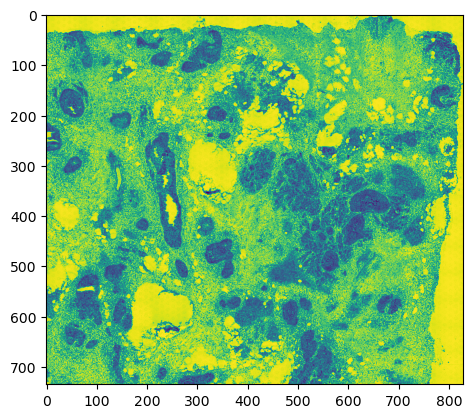

In [203]:
plt.imshow(fixed[0])

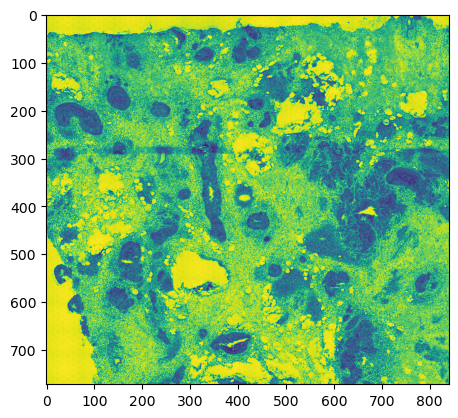

In [204]:
plt.imshow(moving[0])

In [210]:
class RegistrationDataset(Dataset):
    """Registration Dataset"""
    def __init__(self, fixed, moving, target_shape=(256, 256)):
        self.size = max(fixed.shape[1], moving.shape[1], fixed.shape[2], moving.shape[2])
        
        self.fixed = torch.full((fixed.shape[0], self.size, self.size), fixed.min(), dtype=fixed.dtype)
        self.moving = torch.full((moving.shape[0], self.size, self.size), moving.min(), dtype=fixed.dtype)
        
        self.fixed[:, :fixed.shape[1], :fixed.shape[2]] = fixed
        self.moving[:, :moving.shape[1], :moving.shape[2]] = moving
        
        self.fixed = TF.resize(self.fixed, target_shape)
        self.moving = TF.resize(self.moving, target_shape)
        
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        return {
            'fixed': self.fixed,
            'moving': self.moving
        }

In [211]:
ds = RegistrationDataset(fixed, moving)
dl = DataLoader(ds)

In [212]:
b = next(iter(dl))
b['fixed'].shape

torch.Size([1, 1, 256, 256])

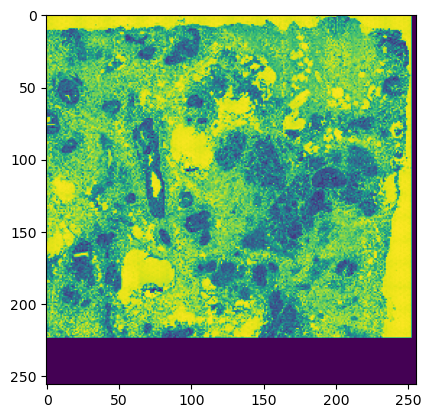

In [213]:
plt.imshow(b['fixed'][0, 0])

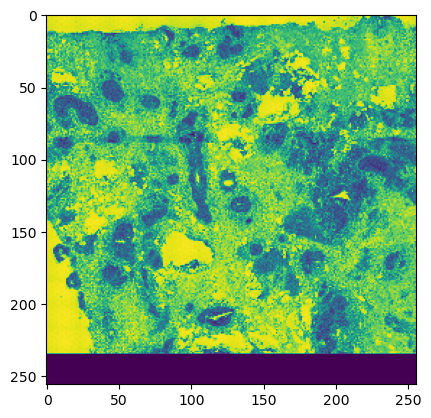

In [214]:
plt.imshow(b['moving'][0, 0])

## model

In [216]:
"""
modified from https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
"""
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet34',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=3,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=False, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x


In [385]:
out[:, :, :, 2:]

tensor([], size=(1, 256, 256, 0, 3), grad_fn=<SliceBackward0>)

In [391]:
out[:, 2:, 1:-1, :].shape

torch.Size([1, 254, 254, 1, 3])

In [394]:
out[:, torch.arange(2, out.shape[1]), 1:-1, :].shape

torch.Size([1, 254, 254, 1, 3])

In [406]:
# adapted from https://github.com/DeepRegNet/DeepReg/blob/main/deepreg/loss/deform.py

def gradient_norm(x, l2=True):
    """x - (b x y z 3)"""
    # if x and y shapes are invalid raise error
    if x.shape[1] < 3 or x.shape[2] < 3:
        raise RuntimeError('cant compute gradient given x and/or y shape')

    dfdx = (x[:, 2:, :, :] - x[:, :-2, :, :]) / 2
    dfdy = (x[:, :, 2:, :] - x[:, :, :-2, :]) / 2
    # ignoring dfdz for now

    if not l2:
        norms = torch.abs(dfdx).mean() + torch.abs(dfdy).mean()
    else:
        norms = (dfdx**2).mean() + (dfdy**2).mean()
    return norms

def bending_energy(x):
    ddf = inputs
    # first order gradient
    # (batch, m_dim1-2, m_dim2-2, m_dim3-2, 3)
    dfdx = (x[:, 2:, 1:-1, 1:-1] - x[:, :-2, 1:-1, 1:-1]) / 2
    dfdy = (x[:, 1:-1, 2:, 1:-1] - x[:, 1:-1, :-2, 1:-1]) / 2
    dfdz = (x[:, 1:-1, 1:-1, 2:] - x[:, 1:-1, 1:-1, :-2]) / 2

    # second order gradient
    # (batch, m_dim1-4, m_dim2-4, m_dim3-4, 3)
    dfdxx = (dfdx[:, 2:, 1:-1, 1:-1] - dfdx[:, :-2, 1:-1, 1:-1]) / 2
    dfdyy = (dfdy[:, 1:-1, 2:, 1:-1] - dfdy[:, 1:-1, :-2, 1:-1]) / 2
    dfdzz = (dfdz[:, 1:-1, 1:-1, 2:] - dfdz[:, 1:-1, 1:-1, :-2]) / 2
    dfdxy = (dfdx[:, 1:-1, 2:, 1:-1] - dfdx[:, 1:-1, :-2, 1:-1]) / 2
    dfdyz = (dfdy[:, 1:-1, 1:-1, 2:] - dfdy[:, 1:-1, 1:-1, :-2]) / 2
    dfdxz = (dfdx[:, 1:-1, 1:-1, 2:] - dfdx[:, 1:-1, 1:-1, :-2]) / 2

    # (dx + dy + dz) ** 2 = dxx + dyy + dzz + 2*(dxy + dyz + dzx)
    energy = dfdxx**2 + dfdyy**2 + dfdzz**2
    energy += 2 * dfdxy**2 + 2 * dfdxz**2 + 2 * dfdyz**2
    return energy.mean()

In [407]:
class RegistrationModel(nn.Module):
    """
    """

    def __init__(self, fixed_shape, backbone='resnet34',
                 intensity_scaler=.5, deformation_scaler=.5):
        super().__init__()
        self.unet = Unet(in_chans=2, num_classes=16, backbone=backbone)
        self.ddfx_layer = nn.Conv2d(16, fixed_shape[0], kernel_size=1)
        self.ddfy_layer = nn.Conv2d(16, fixed_shape[0], kernel_size=1)
        self.ddfz_layer = nn.Conv2d(16, fixed_shape[0], kernel_size=1)
        
        
        self.fixed_shape = fixed_shape # (b, c, h, w)
        self.ref_grid_b, self.ref_grid_c, self.ref_grid_h, self.ref_grid_w = torch.meshgrid(
            torch.arange(self.fixed_shape[0]),
            torch.arange(self.fixed_shape[1]),
            torch.arange(self.fixed_shape[2]),
            torch.arange(self.fixed_shape[3])
        )
        
        # losses
        self.intensity_scaler = intensity_scaler
        self.deformation_scaler = deformation_scaler
        self.mse = nn.MSELoss()
           
    def warp(self, moving, ddf):
        reshaped = rearrange(ddf, 'b x y z a -> b z y x a')
        c_idxs = torch.clamp(torch.round(self.ref_grid_c + reshaped[..., 2]),
                             min=0, max=self.fixed_shape[1] - 1).to(torch.long)
        h_idxs = torch.clamp(torch.round(self.ref_grid_h + reshaped[..., 1]),
                             min=0, max=self.fixed_shape[2] - 1).to(torch.long)
        w_idxs = torch.clamp(torch.round(self.ref_grid_w + reshaped[..., 0]),
                             min=0, max=self.fixed_shape[3] - 1).to(torch.long)
        
        return moving[self.ref_grid_b, c_idxs, h_idxs, w_idxs]
        
    def calculate_loss(self, fixed, warped, ddf):
        intensity_loss = self.mse(warped, fixed)
        
        deformation_loss = gradient_norm(ddf, l2=True)
        
        overall_loss = intensity_loss * self.intensity_scaler + deformation_loss * self.deformation_scaler
        
        return {
            'intensity_loss': intensity_loss,
            'deformation_loss': deformation_loss,
            'overall': overall_loss
        }
        
    def forward(self, fixed, moving):
        """
        fixed - (b, 1, h, w)
        moving - (b, 1, h, w)
        """
        x = torch.concat((fixed, moving), dim=1) # (b, 2, h, w)
        latent = self.unet(x) # (b, 16, h, w)
        
        ddfx = self.ddfx_layer(latent) # (b, 1, h, w)
        ddfy = self.ddfy_layer(latent) # (b, 1, h, w)
        ddfz = self.ddfz_layer(latent) # (b, 1, h, w)
        
        ddf = torch.stack((ddfx, ddfy, ddfz)) # ((xyz), b, 1, h, w)
        ddf = rearrange(ddf, 'a b z y x -> b x y z a')
        
        return ddf

#### basic testing

In [408]:
b = next(iter(dl))

In [409]:
f = RegistrationModel(b['fixed'].shape)

In [410]:
out = f(b['fixed'], b['moving'])

In [411]:
out.shape

torch.Size([1, 256, 256, 1, 3])

In [412]:
m = b['moving'].clone()

In [413]:
w = f.warp(m, out)

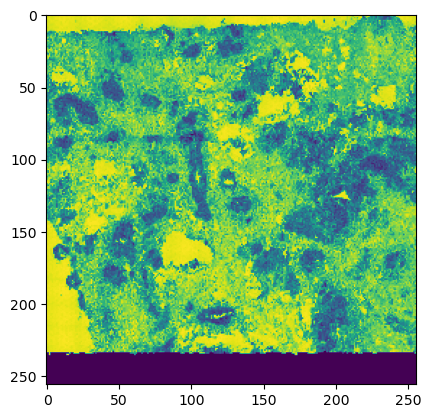

In [414]:
plt.imshow(w[0, 0])

In [416]:
loss = f.calculate_loss(b['fixed'], w, out)

In [417]:
loss

{'intensity_loss': tensor(1.8384),
 'deformation_loss': tensor(0.1589, grad_fn=<AddBackward0>),
 'overall': tensor(0.9986, grad_fn=<AddBackward0>)}

## training